In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima

In [2]:
dfb5 = pd.read_csv('Data/Building Data/Building 5.csv')

In [3]:
dfb5

,Unnamed: 0,series_value,datetime,Year,Month,Day_of_Month,Hour,minutes,series_name
0,0,30.0,2019-07-25 23:00:00,2019,7,25,23,0,Building5
1,4,30.0,2019-07-26 00:00:00,2019,7,26,0,0,Building5
2,8,28.0,2019-07-26 01:00:00,2019,7,26,1,0,Building5
3,12,28.0,2019-07-26 02:00:00,2019,7,26,2,0,Building5
4,16,27.0,2019-07-26 03:00:00,2019,7,26,3,0,Building5
...,...,...,...,...,...,...,...,...,...
2958,44372,19.0,2020-10-30 04:00:00,2020,10,30,4,0,Building5
2959,44376,21.0,2020-10-30 05:00:00,2020,10,30,5,0,Building5
2960,44380,20.0,2020-10-30 06:00:00,2020,10,30,6,0,Building5
2961,44396,1.0,2020-10-30 10:00:00,2020,10,30,10,0,Building5


In [7]:
data = dfb5['series_value'][500:1500]

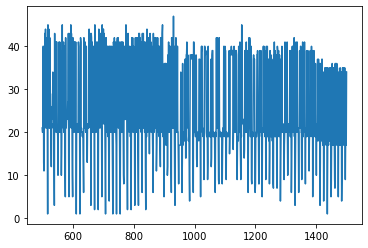

In [8]:
plt.plot(data)

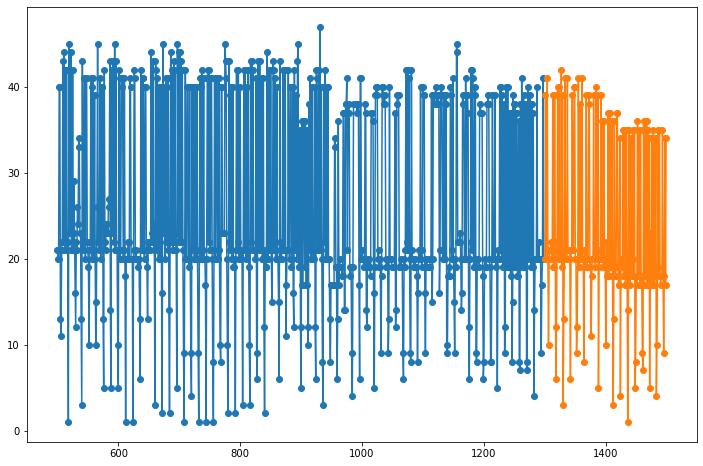

In [9]:
train_size = 0.8

ts = data

split_idx = round(len(data)* train_size)

# Split
train = ts.iloc[:split_idx]
test = ts.iloc[split_idx:]

# Visualize split
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(train, label='Train', **kws)
plt.plot(test, label='Test', **kws)

In [10]:
modelactual = auto_arima(train, start_p=0, start_q=0, seasonal=True)
modelactual.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  800
Model:               SARIMAX(2, 0, 1)   Log Likelihood               -3078.717
Date:                Tue, 27 Sep 2022   AIC                           6167.434
Time:                        23:26:49   BIC                           6190.857
Sample:                             0   HQIC                          6176.432
                                - 800                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     36.2413      5.086      7.126      0.000      26.274      46.209
ar.L1         -0.3467      0.229     -1.515      0.130      -0.795       0.102
ar.L2         -0.0785      0.049     -1.619      0.106      -0.174       0.017
ma.L1          0.4377      0.227      1.929      0.054      -0.007       0.882
sigma2       128.8777      9.769     13.193      0.000     109.731     148.024
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                42.18
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                             0.24
Prob(H) (two-sided):                  0.09   Kurtosis:                         1.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [13]:
data = train
# define model
my_order = (2, 1, 1)
my_seasonal_order = (2, 1, 1, 24)
model = SARIMAX(data, order=my_order, seasonal_order=my_seasonal_order)
# fit model
model_fit = model.fit()
# one step forecast
yhat = model_fit.predict(end=len(test))

In [14]:
yhat

500     0.000000
501    20.998072
502    20.000033
503    20.000119
504    39.996324
         ...    
696    12.424292
697    28.527262
698    23.598227
699    24.898267
700    26.745031
Name: predicted_mean, Length: 201, dtype: float64

In [15]:
lst = []
for i in range(501, 701):
    lst.append(yhat[i])

In [16]:
forecastdf = pd.DataFrame(lst, columns=['forecast']) 

In [17]:
test

1300    20.0
1301    39.0
1302    20.0
1303    21.0
1304    41.0
        ... 
1495     9.0
1496    18.0
1497    34.0
1498    17.0
1499    34.0
Name: series_value, Length: 200, dtype: float64

In [18]:
lst = []
for i in range(1300, 1500):
    lst.append(test[i])

In [19]:
testdfnew = pd.DataFrame(lst, columns=['test']) 

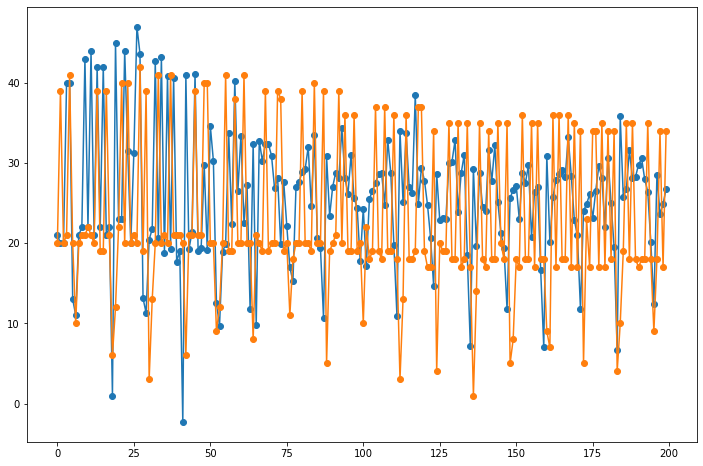

In [21]:
fig,ax= plt.subplots(figsize=(12,8))
kws = dict(marker='o')
plt.plot(forecastdf['forecast'], label='Forecast', **kws)
plt.plot(testdfnew['test'], label='Test', **kws)

In [22]:
from sklearn.metrics import mean_absolute_error
import numpy as np

def mean_absolute_scaled_error(y_true, y_pred, y_train):
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    return np.mean(np.abs(e_t / scale))


pred = forecastdf['forecast'] 
tst = testdfnew['test']
trn = train

mean_absolute_scaled_error(pred,tst,trn)

0.8896737556558449